In [18]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

from dataclasses import dataclass
from typing import Callable, List, Optional, Tuple

In [19]:
# dynamics of the pendulum
@dataclass
class Gaussian:
    mean: np.ndarray
    cov: np.ndarray


DT = 0.01
G = sp.constants.g


def xkp1(xk: np.ndarray) -> np.ndarray:
    xkp1 = np.zeros(2)
    xkp1[0] = xk[0] + xk[1]*DT
    xkp1[1] = xk[1] - G*np.sin(xk[0])*DT
    return xkp1


def get_q() -> np.ndarray:
    QC = 0.1
    return np.array([[QC*DT**3/3, QC*DT**2/2],
                     [QC*DT**2/2, QC*DT]])


def yk(xk: np.ndarray) -> np.ndarray:
    return np.array([np.sin(xk[0])])

In [20]:
# setup the problem

@dataclass
class Observations:
    times: np.ndarray
    obs_ind: np.ndarray  # index of times that are observed
    obs: np.ndarray
    names: List[str]


def generate_truth(x0: np.ndarray, dt: float, N: int) -> Observations:
    times = np.zeros(N+1)  # from 0 to N times
    xk = np.zeros((N+1, 2))  # state at each time
    xk[0] = x0
    for i in range(1, N+1):
        times[i] = i*dt
        xk[i] = xkp1(xk[i-1])
    return Observations(times, np.arange(N+1), xk, [r'$x_1$ true', r'$x_2$ true'])


def generate_obs(truth: Observations, delta: float, R: float) -> Observations:
    process_std = np.linalg.cholesky(get_q())
    measure_std = np.sqrt(R)
    measure_ind = np.arange(delta, truth.obs_ind[-1]+1, delta)
    obs = np.zeros((measure_ind.size, 1))
    obs_ind = 0
    for i in measure_ind:
        obs[obs_ind] = yk(truth.obs[i] +
                          np.dot(process_std, np.random.randn(2))) + measure_std*np.random.randn()
        obs_ind += 1
    return Observations(truth.times, measure_ind, obs, [r'$x_1$ obs'])


@dataclass
class ObservationData:
    delta: float
    R: float
    obs: Observations


N = 500
X0 = np.array([1.5, 0])
truth = generate_truth(X0, DT, N)
deltas = [5, 10, 20, 40]
Rs = [0.001, 0.01, 0.1, 1]
data = []
for delta in deltas:
    for R in Rs:
        data.append(ObservationData(delta, R, generate_obs(truth, delta, R)))

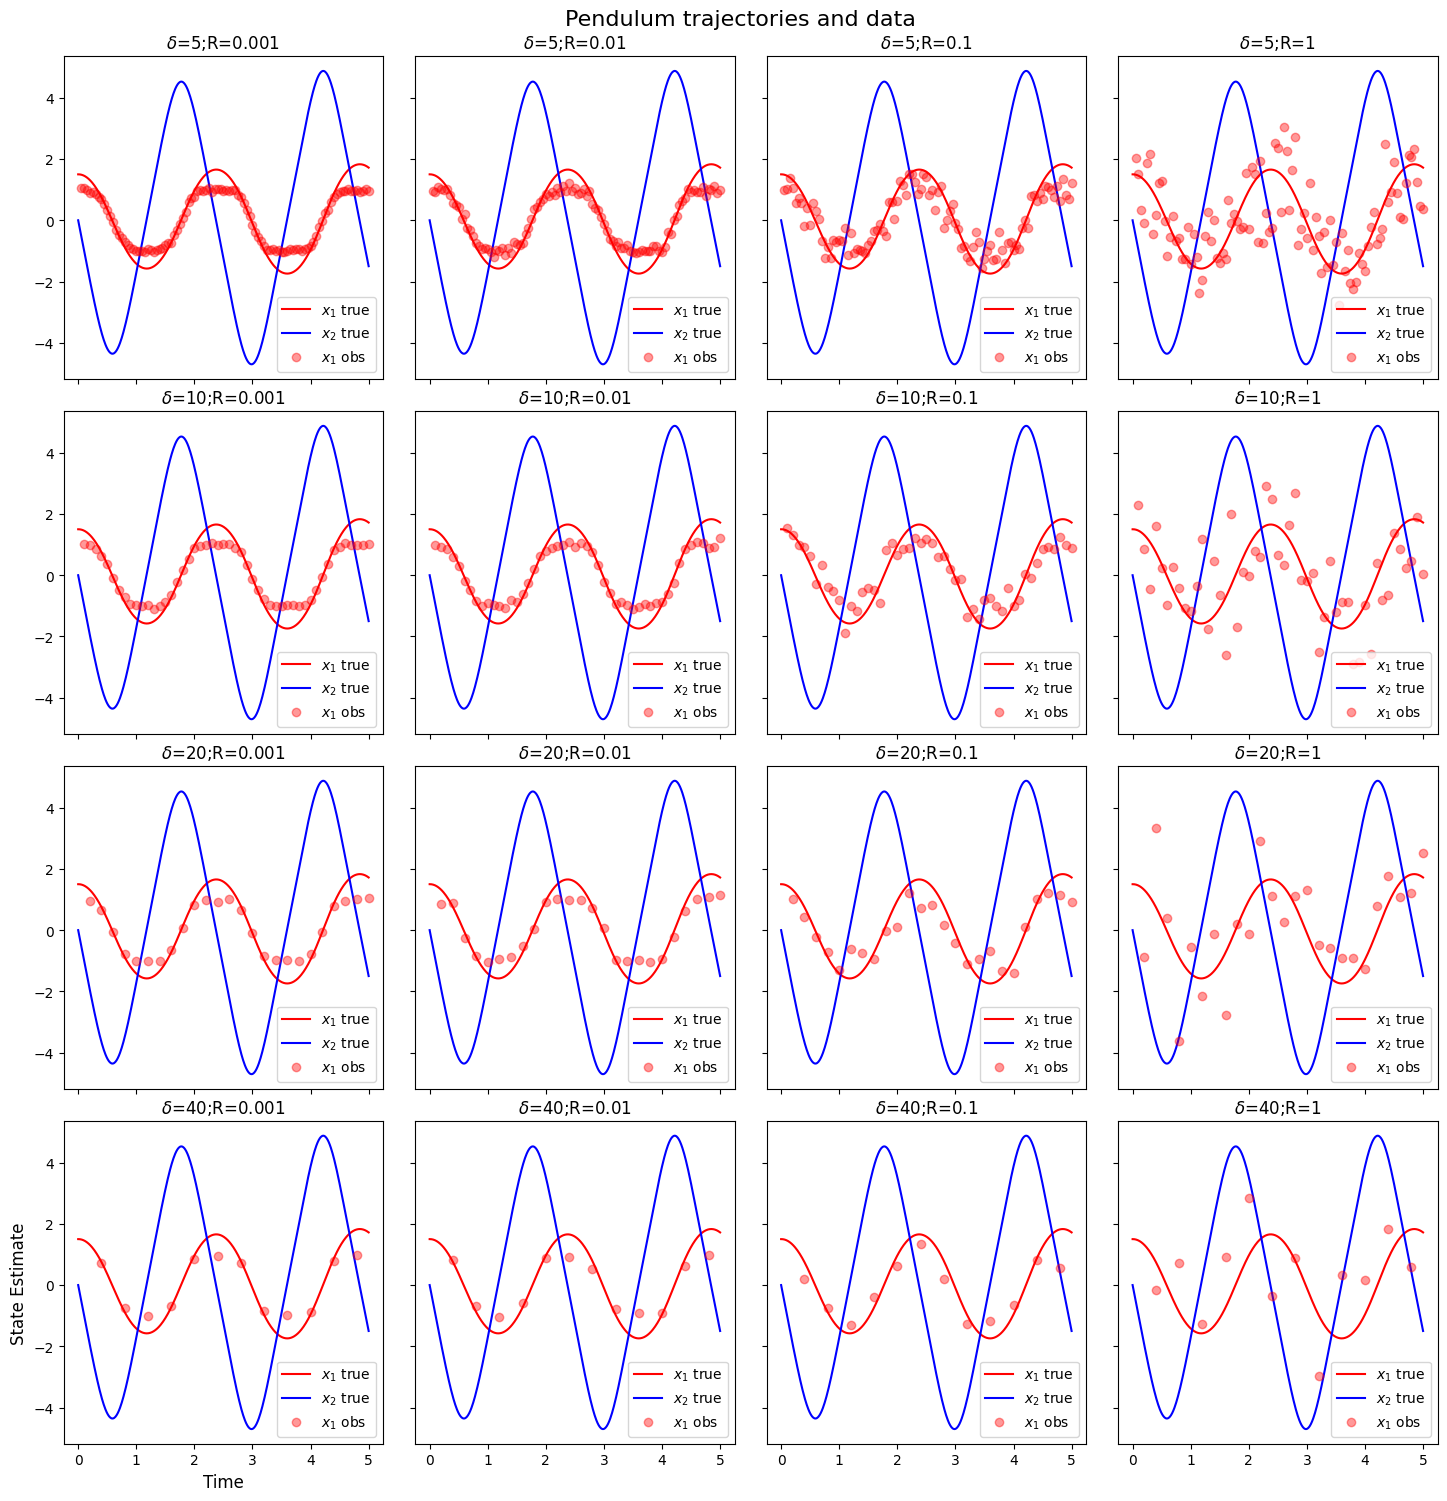

In [21]:
# setup helper functions


@dataclass
class KFTracker:
    means: np.ndarray
    covs: np.ndarray
    stds: np.ndarray


def plot_data_and_truth(fignum, title, true_obs: Observations, data_obs: List[ObservationData],
                        kft: Optional[List[KFTracker]] = None) -> plt.figure:

    colors = ['red', 'blue']
    plt.close(fignum)
    fig, axs = plt.subplots(4, 4, num=fignum, figsize=(15, 15), sharex=True, sharey=True)
    fig.tight_layout(pad=3)
    fig.suptitle(title, fontsize=16, y=1.0)
    for i in range(len(data_obs)):
        ax = axs[i//4, i % 4]
        ax.plot(true_obs.times, true_obs.obs[:, 0], color=colors[0], label=true_obs.names[0])
        ax.plot(true_obs.times, true_obs.obs[:, 1], color=colors[1], label=true_obs.names[1])

        ax.plot(data_obs[i].obs.times[data_obs[i].obs.obs_ind], data_obs[i].obs.obs,
                'o', color=colors[0], alpha=0.4, label=data_obs[i].obs.names[0])

        if kft is not None:
            ax.plot(data_obs[i].obs.times, kft[i].means[:, 0],
                    '--', color=colors[0], label=r'est $x_1$')
            ax.plot(data_obs[i].obs.times, kft[i].means[:, 1],
                    '--', color=colors[1], label=r'est $x_2$')
            ax.fill_between(data_obs[i].obs.times,
                            kft[i].means[:, 0] - 2 * kft[i].stds[:, 0],
                            kft[i].means[:, 0] + 2 * kft[i].stds[:, 0],
                            color=colors[0], alpha=0.3)
            ax.fill_between(data_obs[i].obs.times,
                            kft[i].means[:, 1] - 2 * kft[i].stds[:, 1],
                            kft[i].means[:, 1] + 2 * kft[i].stds[:, 1],
                            color=colors[1], alpha=0.3)
            ax.set_title(
                r'$\delta$=' +
                f'{data_obs[i].delta};R={data_obs[i].R};MSE={mean_sq_error(true_obs, kft[i]):.3f}',
                fontsize=12)
        else:
            ax.set_title(r'$\delta$='+f'{data_obs[i].delta};R={data_obs[i].R}', fontsize=12)
        ax.legend()
    axs[3, 0].set_xlabel('Time', fontsize=12)
    axs[3, 0].set_ylabel('State Estimate', fontsize=12)
    fig.subplots_adjust(hspace=0.1, wspace=0.1)
    fig.savefig(f'figs/{title}.svg')
    plt.show()
    return fignum + 1


def mean_sq_error(truth: Observations, results: KFTracker) -> float:
    return np.mean((truth.obs - results.means)**2)


fignum = 1

fignum = plot_data_and_truth(fignum, 'Pendulum trajectories and data', truth, data)

delta=5 	R=0.001	MSE=3.1e-02
delta=5 	R=0.01	MSE=3.2e-02
delta=5 	R=0.1	MSE=2.0e-01
delta=5 	R=1	MSE=8.9e-02
delta=10 	R=0.001	MSE=8.5e-03
delta=10 	R=0.01	MSE=2.1e-02
delta=10 	R=0.1	MSE=1.1e-01
delta=10 	R=1	MSE=8.1e-01
delta=20 	R=0.001	MSE=5.9e-03
delta=20 	R=0.01	MSE=1.6e-01
delta=20 	R=0.1	MSE=1.4e-01
delta=20 	R=1	MSE=2.4e+00
delta=40 	R=0.001	MSE=1.1e-02
delta=40 	R=0.01	MSE=1.0e-01
delta=40 	R=0.1	MSE=5.5e-01
delta=40 	R=1	MSE=5.1e+00


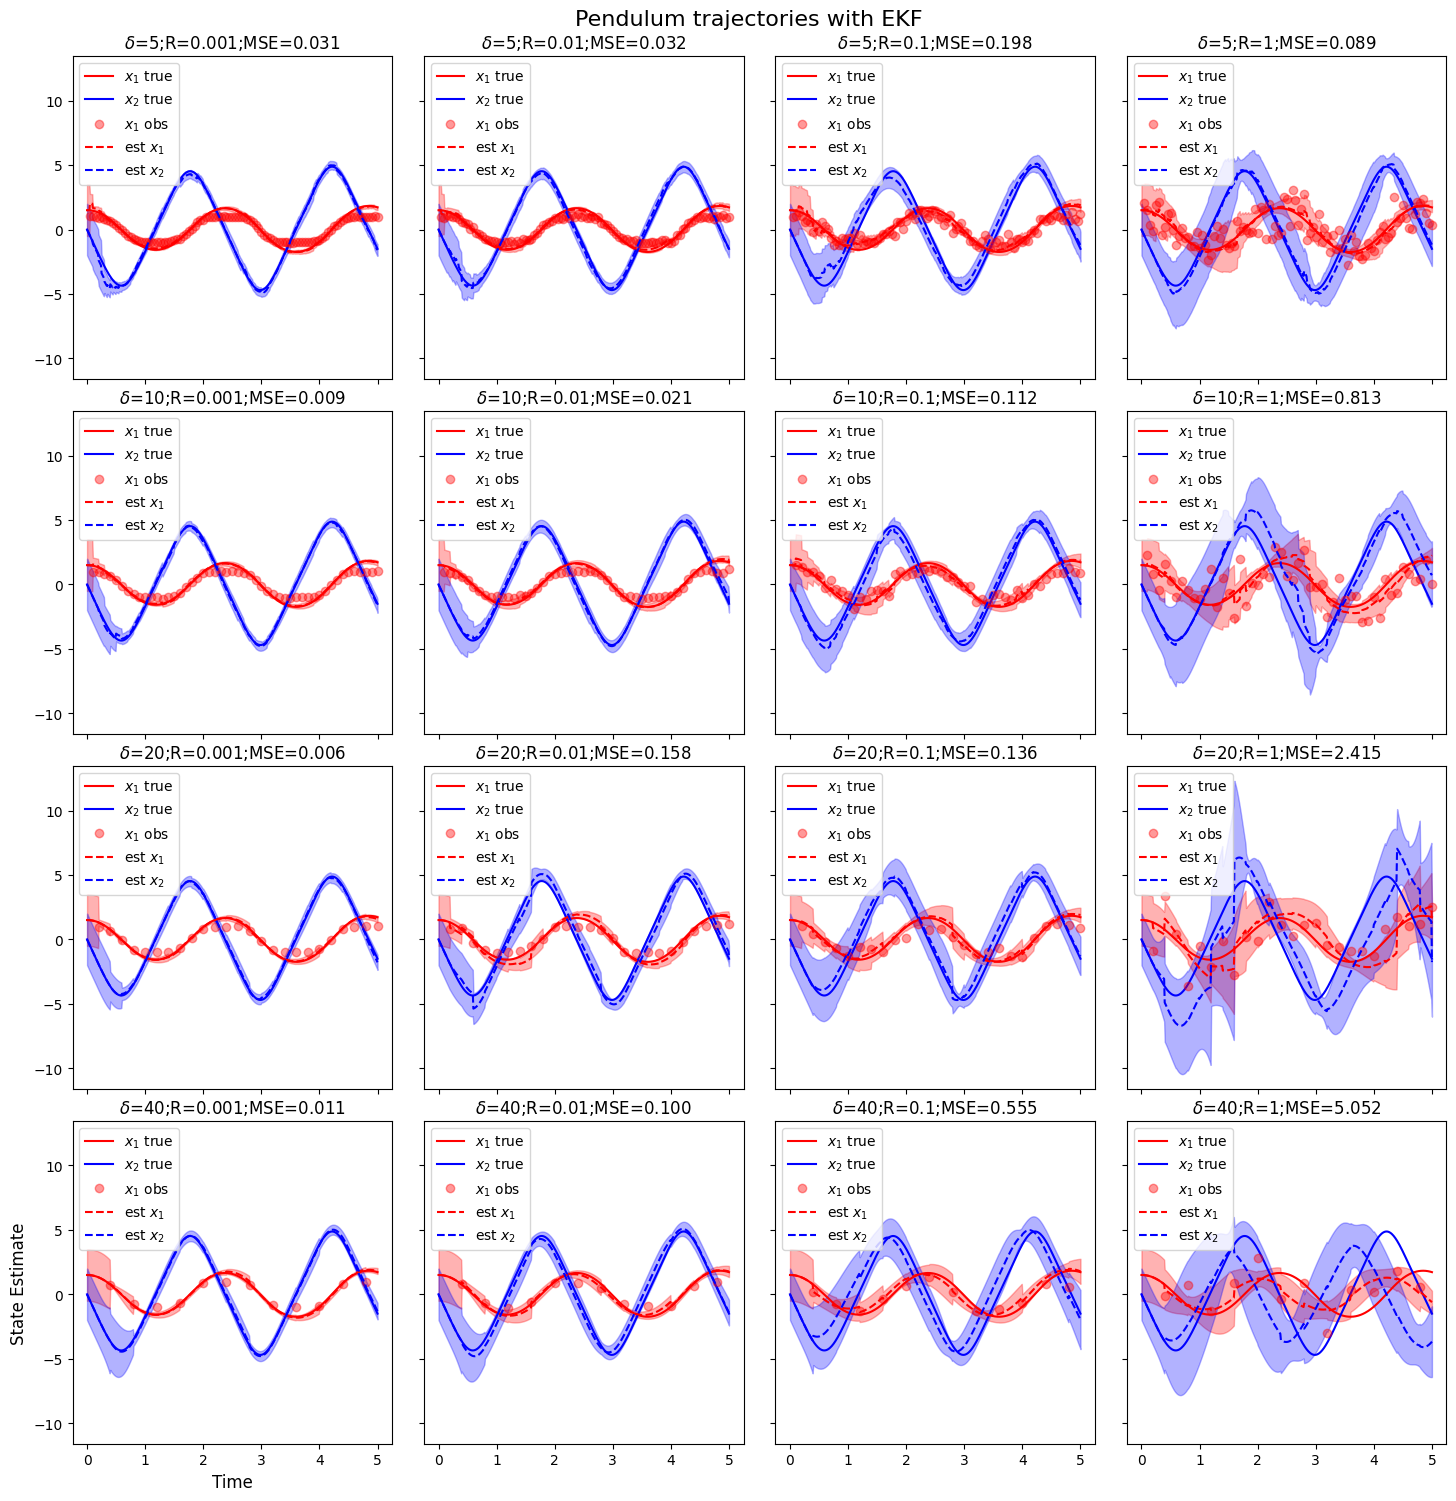

In [22]:
# extended kalman filter

def predict(phi: Callable[[np.ndarray], np.ndarray], A: np.ndarray,
            X: Gaussian, xi: Gaussian) -> Gaussian:
    """Linear Prediction Step: Propagate uncertainty for one time step.

    X_{k+1} = A X_{k} + xi, xi sim mathcal{N}{noise_mean, noise_cov}
    X_{k} sim mathcal{N}(mean, cov)

    Inputs
    ------
    phi: dynamics function
    A: (d, d), linearized dynamics
    X: Gaussian
    xi: Gaussian

    Returns
    -------
    A Gaussian random variable for the next time step
    """

    pred_mean = phi(X.mean) + xi.mean
    pred_cov = np.dot(A, np.dot(X.cov, A.T)) + xi.cov
    return Gaussian(pred_mean, pred_cov)


def update(data: np.ndarray, h: Callable[[np.ndarray], np.ndarray], H: np.ndarray,
           X: Gaussian, eta: Gaussian) -> Gaussian:
    """Linear Gaussian Inverse Problem.

    Inputs
    ------
    data: (N) array of data
    h: observation function
    H: (m, d), linearized observation model
    X: Gaussian
    eta: Gaussian

    Returns
    -------
    Gaussian Posterior
    """
    U = np.dot(X.cov, H.T)
    S = np.dot(H, U) + eta.cov
    mu = h(X.mean) + eta.mean

    update_mean = X.mean + np.dot(U, np.linalg.solve(S, data - mu))
    update_cov = X.cov - np.dot(U, np.linalg.solve(S, U.T))
    return Gaussian(update_mean, update_cov)


def extended_kalman_filter(data: Observations,
                           phi: Callable[[np.ndarray], np.ndarray],
                           A: Callable[[np.ndarray], np.ndarray],
                           h: Callable[[np.ndarray], np.ndarray],
                           H: Callable[[np.ndarray], np.ndarray],
                           prior: Gaussian,
                           xi: Gaussian, eta: Gaussian) -> Tuple[np.ndarray, np.ndarray]:
    """The Kalman filter.

    Inputs
    ------
    data: (N, m), N is the number of time steps, m is the size of the observations
    phi: dynamics function
    A: linearized dynamics function
    h: observation function
    H: linearized observation function
    prior: prior Gaussian
    xi: process noise
    eta: measurement noise

    Return
    ------
    KFTracker
    """

    num_steps = data.times.shape[0]

    d = prior.mean.shape[0]
    mean_store = np.zeros((num_steps, d))
    mean_store[0, :] = np.copy(prior.mean)
    cov_store = np.zeros((num_steps, d, d))
    cov_store[0, :, :] = np.copy(prior.cov)

    std_store = np.zeros((num_steps, d))
    std_store[0, :] = np.sqrt(np.diag(cov_store[0, :, :]))

    # Loop over all time steps
    Xnext = prior
    on_obs = 0
    for ii in range(1, num_steps):
        # Prediction
        Xpred = predict(phi, A(Xnext.mean), Xnext, xi)

        # We have an observation so an update must occur
        if on_obs < data.obs_ind.shape[0] and ii == data.obs_ind[on_obs]:
            y = data.obs[on_obs]
            on_obs += 1

            # Update
            Xup = update(y, h, H(Xpred.mean), Xpred, eta)
            Xnext = Xup

        else:
            Xnext = Xpred

        mean_store[ii, :] = np.copy(Xnext.mean)
        cov_store[ii, :, :] = np.copy(Xnext.cov)
        std_store[ii, :] = np.sqrt(np.diag(cov_store[ii, :, :]))

    return KFTracker(mean_store, cov_store, std_store)

# linearized dynamics


def Ak(xk: np.ndarray) -> np.ndarray:
    return np.array([[1, DT],
                     [-G*np.cos(xk[0])*DT, 1]])


def Hk(xk: np.ndarray) -> np.ndarray:
    return np.array([[np.cos(xk[0]), 0]]).reshape(1, 2)


prior = Gaussian(X0, np.eye(2))
process_cov = Gaussian(np.zeros(2), get_q())
kf_results = []
for obs in data:
    kf_results.append(extended_kalman_filter(obs.obs, xkp1, Ak, yk,
                      Hk, prior, process_cov, Gaussian(0, obs.R)))

for result, obs in zip(kf_results, data):
    mse = mean_sq_error(truth, result)
    print(f'delta={obs.delta} \tR={obs.R}\tMSE={mse:.1e}')

fignum = plot_data_and_truth(fignum, 'Pendulum trajectories with EKF', truth, data, kf_results)

In [23]:
# unscented kalman filter of order 3